# Burst Clustering of Spike Trains

In [2]:
%matplotlib inline

In [15]:
import pandas as pd
import numpy as np
import scipy.sparse as sp
import seaborn as sns
import matplotlib.pyplot as plt

In [16]:
sns.set(style='whitegrid')

In [21]:
def loadfile(filepath, neurons):
    arr  = np.loadtxt(filepath, dtype='int', delimiter=",")
    timesteps = arr[-1, 0]
    spikes = sp.coo_matrix((arr[:,2], (arr[:,0]-1, arr[:, 1]-1)), (timesteps, neurons)).tocsc()
    return spikes

In [22]:
def getISI(spikes, neurons):
    isi = np.empty(0)
    for i in range(neurons):
        spiketrain = spikes[:, i].indices
        if(len(spiketrain) > 3):
            interval1 = np.diff(spiketrain, 1)
            interval2 = np.diff(spiketrain, 2)
            b = (2 * np.var(interval1) - np.var(interval2)) / (2 * (np.mean(interval1) ** 2))
            isi = np.append(isi, interval1)
    return isi

In [23]:
def plotHist(data, xmin, xmax, nbins):
    hist, bins = np.histogram(data, range=(xmin, xmax), bins=nbins, density=True)
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.bar(center, hist, align='center', width=width)
    plt.show()

In [114]:
def plotHistDiff(data1, data2, xmin, xmax, nbins):
    hist1, bins = np.histogram(data1, range=(xmin, xmax), bins=nbins, density=True)
    hist2, bins = np.histogram(data2, range=(xmin, xmax), bins=nbins, density=True)
    hist = hist1 - hist2
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.bar(center, hist, align='center', width=width)
    plt.show()

In [100]:
def getClusters(spikes, threshold, neurons):
    clusters = np.empty(0)
    clusters_mean = np.empty(0)
    num_spikes = np.empty(0)
    burstLength = np.empty(0)
    longLength = np.empty(0)
    for i in range(neurons):
        spiketrain = spikes[:, i].indices
        if(len(spiketrain) > 3):
            interval1 = np.log10(np.diff(spiketrain, 1))
            clust = np.zeros(1)
            bsize = np.zeros(1)
            idx = 0
            for j in range(len(interval1)):
                if(interval1[j] <= threshold):
                    clust[idx] += 1
                    bsize[idx] += interval1[j]
                elif(clust[idx] < 3):
                    clust[idx] = 0
                    bsize[idx] = 0
                else:
                    clust = np.append(clust, 0)
                    bsize = np.append(bsize, 0)
                    idx += 1
            if(clust[idx] < 3):
                clust = clust[0:idx-1]
                bsize = bsize[0:idx-1]
            if(len(clust) > 0 and clust[0] > 0):
                clusters      = np.append(clusters, len(clust))
                clusters_mean = np.append(clusters_mean, np.mean(clust))
                num_spikes    = np.append(num_spikes, len(spiketrain))
                burstLength    = np.append(burstLength, np.mean(bsize/clust))
                longLength    = np.append(longLength, np.mean(interval1[interval1 > threshold]))
                
    return {'num':clusters, 'size':clusters_mean, 'nspikes':num_spikes, 'blen':burstLength, 'llen':longLength}

In [73]:
neurons = 7520
high = loadfile("SampleLogs/HighConst_Firing.csv", neurons)
med  = loadfile("SampleLogs/MediumConst_Firing.csv", neurons)
low  = loadfile("SampleLogs/LowConst_Firing.csv", neurons)

In [74]:
isi_high = getISI(high, neurons)
isi_med  = getISI(med, neurons)
isi_low  = getISI(low, neurons)

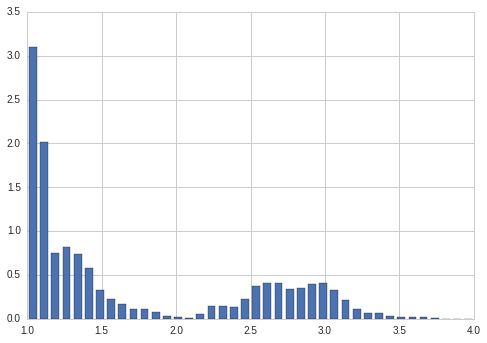

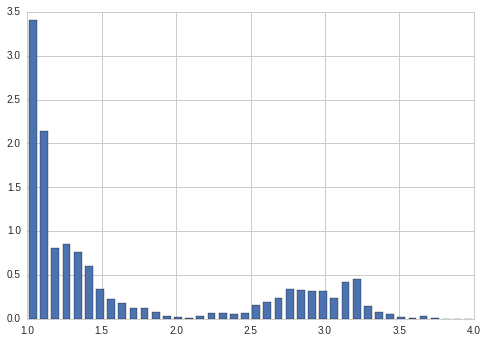

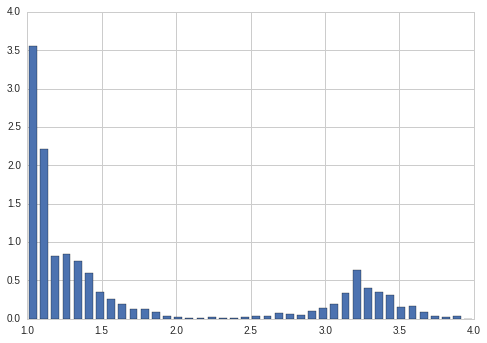

In [112]:
plotHist(np.log10(isi_high), 1, 4, 40)
plotHist(np.log10(isi_med), 1, 4, 40)
plotHist(np.log10(isi_low), 1, 4, 40)

In [113]:
threshold = 2
highClust = getClusters(high, threshold, neurons)
medClust = getClusters(med, threshold, neurons)
lowClust = getClusters(low, threshold, neurons)

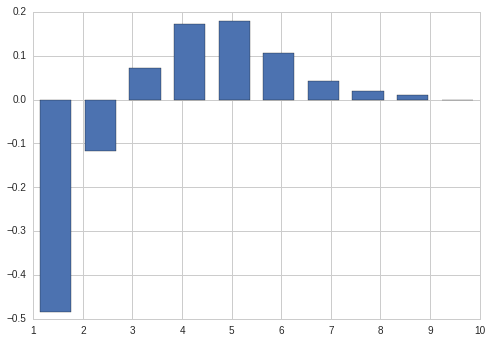

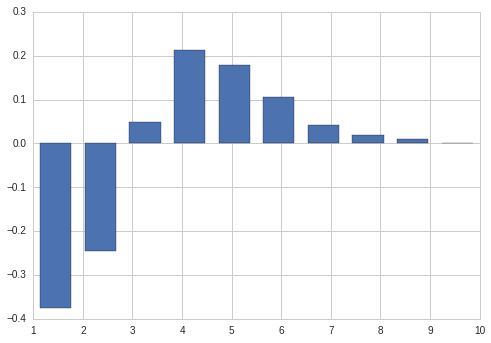

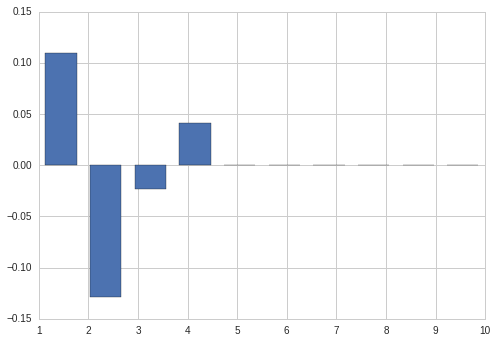

In [115]:
plotHistDiff(highClust['num'], medClust['num'], 1, 10, 10)
plotHistDiff(highClust['num'], lowClust['num'], 1, 10, 10)
plotHistDiff(medClust['num'], lowClust['num'], 1, 10, 10)

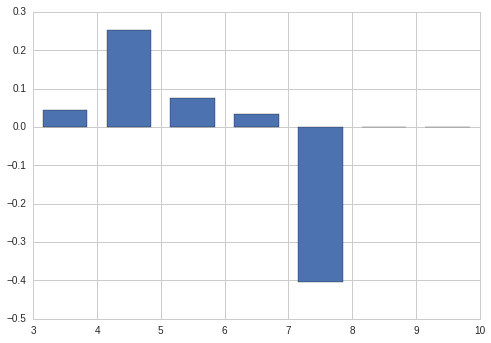

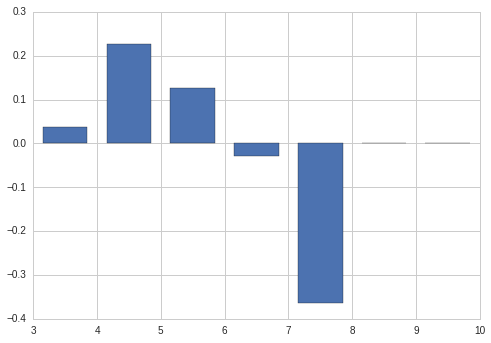

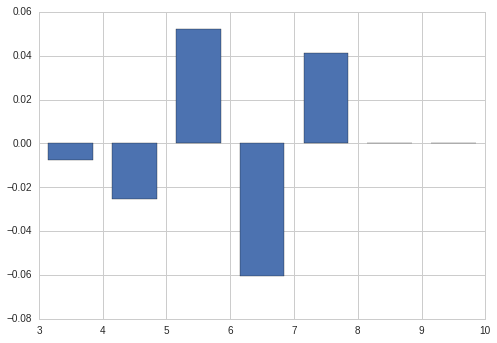

In [116]:
plotHistDiff(highClust['size'], medClust['size'], 3, 10, 7)
plotHistDiff(highClust['size'], lowClust['size'], 3, 10, 7)
plotHistDiff(medClust['size'], lowClust['size'], 3, 10, 7)

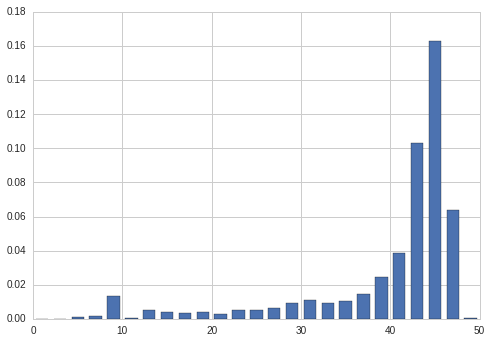

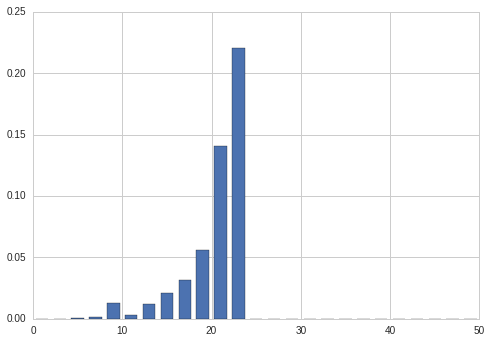

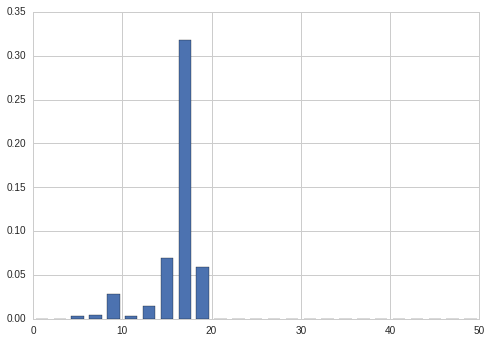

In [104]:
plotHist(highClust['nspikes'], 0, 50, 25)
plotHist(medClust['nspikes'], 0, 50, 25)
plotHist(lowClust['nspikes'], 0, 50, 25)

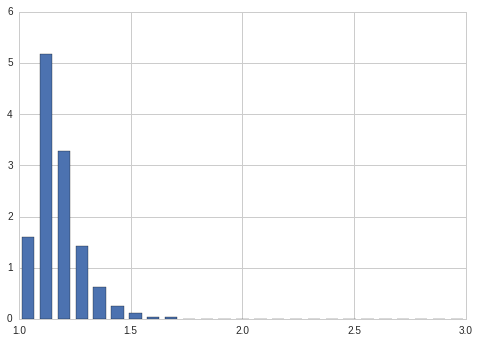

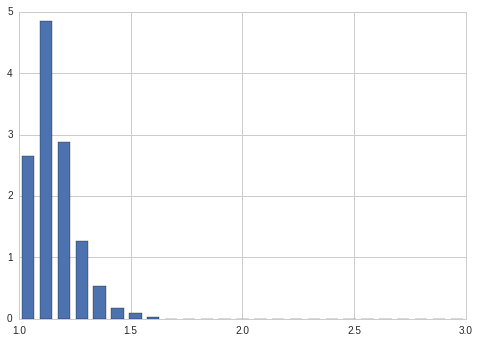

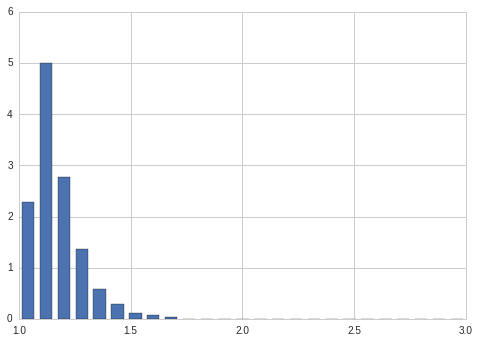

In [107]:
plotHist(highClust['blen'], 1, 3, 25)
plotHist(medClust['blen'], 1, 3, 25)
plotHist(lowClust['blen'], 1, 3, 25)

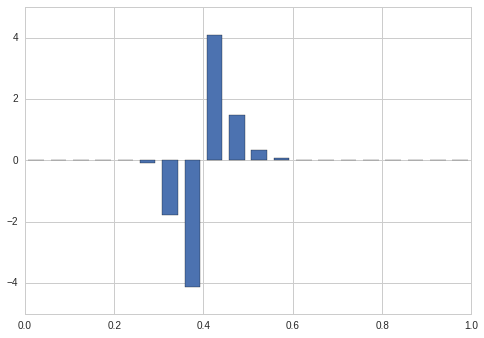

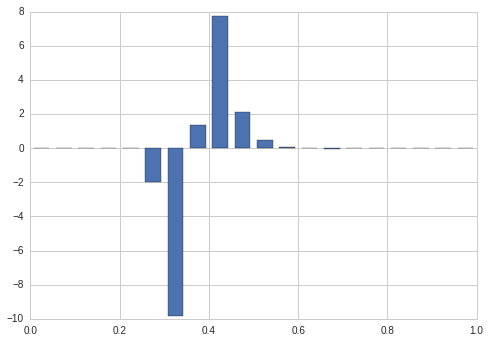

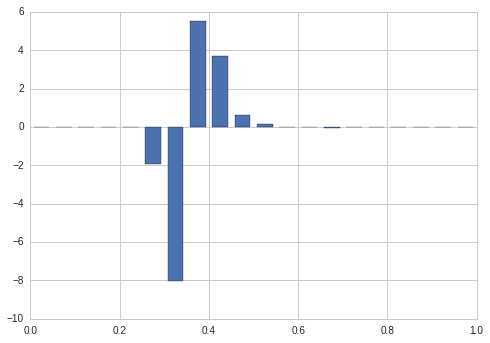

In [121]:
hrat = highClust['blen']/highClust['llen']
mrat = medClust['blen']/medClust['llen']
lrat = lowClust['blen']/lowClust['llen']
plotHistDiff(hrat, mrat, 0, 1, 20)
plotHistDiff(hrat, lrat, 0, 1, 20)
plotHistDiff(mrat, lrat, 0, 1, 20)